# Top-k upper bounds

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from analysis import selection
from postgres import explain
from transform import db, mosp

In [3]:
def read_workload(topk_length: int = np.nan, raw: str = "") -> pd.DataFrame:
    path = f"workloads/topk-setups/job-ues-results-topk-{topk_length}-linear.csv" if not raw else raw
    df = pd.read_csv(path, converters={"query": mosp.MospQuery.parse, "ues_bounds": json.loads, "query_result": json.loads})
    df = selection.best_query_repetition(df, "label", performance_col="query_rt_total")
    df = selection.reorder(df)
    df.set_index("label", inplace=True)
    df["ues_final_bound"] = df["ues_final_bound"].astype("float")
    
    df.rename(columns={"query_rt_total": "rt", "ues_final_bound": "bound"}, inplace=True)
    if not raw:
        df["mode"] = "top-k"
        df["topk_length"] = topk_length
    else:
        df["mode"] = "ues"
        df["topk_length"] = 0
    return df

In [4]:
print("Reading UES")
df_ues = read_workload(raw="workloads/job-ues-results-base-linear.csv")

print("Reading Top-5")
df_top5 = read_workload(5)

print("Reading Top-15")
df_top15 = read_workload(15)

print("Reading Top-50")
df_top50 = read_workload(50)

print("Reading Top-100")
df_top100 = read_workload(100)

Reading UES
Reading Top-5
Reading Top-15
Reading Top-50
Reading Top-100


In [5]:
{"ues": df_ues.rt.sum(),
 "top-5": df_top5.rt.sum(),
 "top-15": df_top15.rt.sum(),
 "top-50": df_top50.rt.sum(),
 "top-100": df_top100.rt.sum()
}

{'ues': 397.169805,
 'top-5': 408.55763700000006,
 'top-15': 407.222416,
 'top-50': 408.96534,
 'top-100': 413.66970999999995}

In [6]:
df = pd.concat([df_ues, df_top5, df_top15, df_top50, df_top100])
df.reset_index(inplace=True)
df["setting"] = df["mode"] + " // " + df["topk_length"].astype(str)

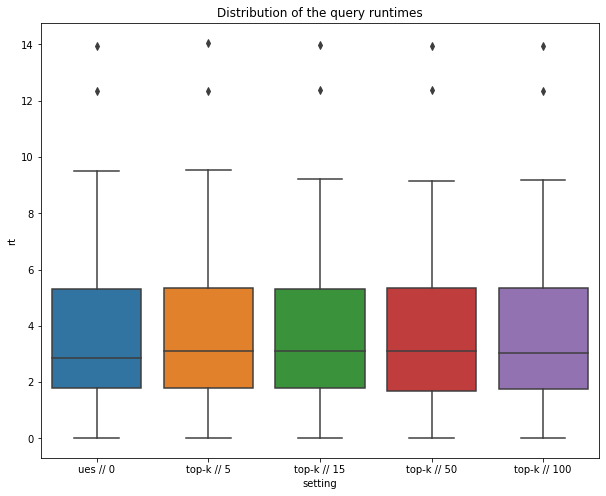

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
g = sns.boxplot(data=df, x="setting", y="rt", ax=ax)
__ = g.set_title("Distribution of the query runtimes")

In [8]:
df = pd.concat([
    pd.merge(df_ues[["bound", "rt"]], df_top5[["bound", "rt", "topk_length"]], right_index=True, left_index=True, suffixes=("_ues", "_topk")),
    pd.merge(df_ues[["bound", "rt"]], df_top15[["bound", "rt", "topk_length"]], right_index=True, left_index=True, suffixes=("_ues", "_topk")),
    pd.merge(df_ues[["bound", "rt"]], df_top50[["bound", "rt", "topk_length"]], right_index=True, left_index=True, suffixes=("_ues", "_topk")),
    pd.merge(df_ues[["bound", "rt"]], df_top100[["bound", "rt", "topk_length"]], right_index=True, left_index=True, suffixes=("_ues", "_topk")),
])
df.reset_index(inplace=True)
df["bound_improvement"] = df["bound_ues"] / df["bound_topk"]
df.groupby("topk_length")["bound_improvement"].describe()

,count,mean,std,min,25%,50%,75%,max
topk_length,,,,,,,,
5,113.0,336.114002,1110.605748,1.0,2.288278,6.123554,132.483742,7889.224138
15,113.0,562.465800,1587.913410,1.0,9.696450,37.944849,337.457563,10766.470588
50,113.0,1390.761335,2779.176334,1.0,23.824586,166.484162,1523.769872,15407.860782
100,113.0,11717.538078,83305.243653,1.0,18.434108,50.902258,244.206385,646810.018810


<AxesSubplot:xlabel='topk_length', ylabel='bound_improvement'>

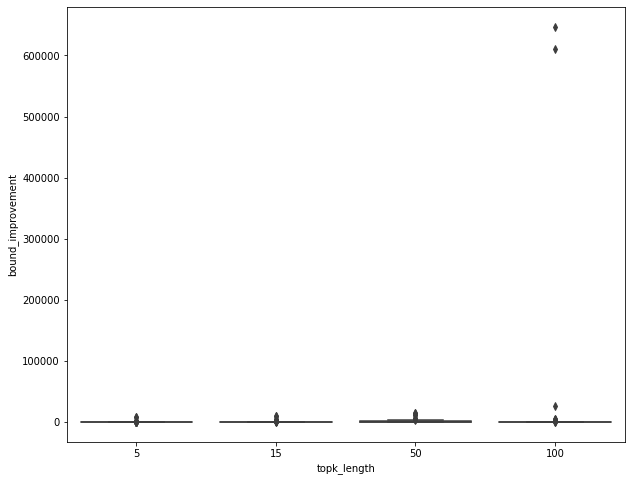

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x="topk_length", y="bound_improvement")

<AxesSubplot:xlabel='topk_length', ylabel='bound_improvement'>

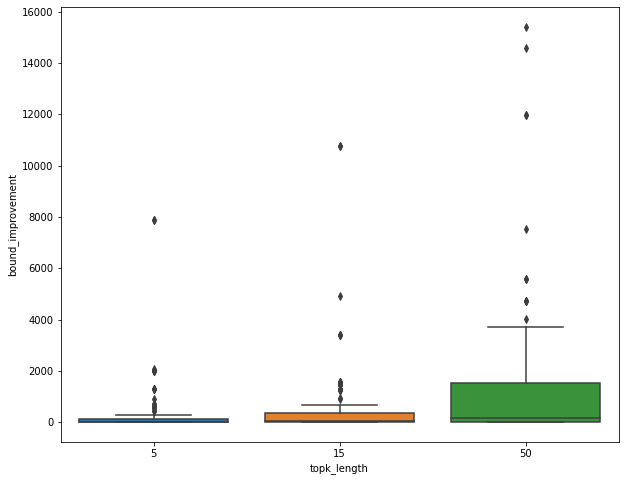

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df[df["topk_length"] < 100], x="topk_length", y="bound_improvement")